# Visualization in Python

## Background

Why visualize?
- Discovery
- Inference
- Communication


Terminology
- Representation
 - Environment for visualization (e.g., 2d, 3d, sound)
- Idiom
 - Constructs used (e.g., bar plot, area plot)
- Task
 - What the user is trying to do (e.g., compare, predict, find relationships)
- Design
 - Choice of the representation(s) and idiom(s) to perform the task


## Software Engineering & Visualization

There are many python packages for visualization.
- pandas – Visualization of pandas objects
- matplotlib – MATLAB plotting in python
- seaborn – Statistical visualizations
- bokeh – Interactive visualization using the browser
- HoloViews – Simplified visualization of engineering/scientific data
- VisPy – fast, scalable, simple interactive scientific visualization
- Altair – declarative statistical visualization


We'll begin with visualization in pandas and focus on matplotlib. There is great documentation on all of this.
The case study is to analyze the flow of bicycles out of stations in the Pronto trip data.
In this section, we'll discuss:
- the structure of a matplotlib plot
- different plot idioms
- doing multiple plots

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# The following ensures that the plots are in the notebook
%matplotlib inline
# We'll also use capabilities in numpy
import numpy as np

Analysis questions
- Which stations have the biggest difference between in-flow and out-flow of bikes?
- Where can we localize the movement of bicycles between stations that are in close proximity?

## Preparing Data For Visualization

In [2]:
df = pd.read_csv("2015_trip_data.csv")
df.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1960
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1970
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1988
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1977
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1971


Now let's consider the flow of bicycles from and to stations.

In [3]:
from_counts = pd.value_counts(df.from_station_id)
to_counts = pd.value_counts(df.to_station_id)

In [4]:
from_counts.head()

WF-01     6742
BT-01     5885
CBD-13    5385
CH-07     5190
SLU-15    5006
Name: from_station_id, dtype: int64

## Simple Plots for Series

Let's address the question "Which stations have the biggest difference between the in-flow and out-flow of bicycles?"

What kind of objects are returned from pd.value_counts? Are these plottable? How do we figure this out?

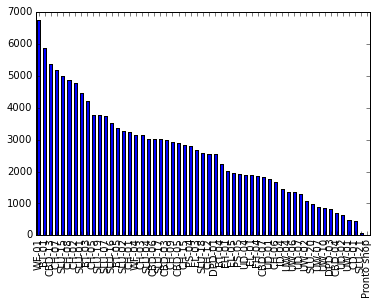

In [5]:
from_counts.plot.bar()

We can compare from and to counts with sidey-by-side plots. But to do this, we need a DataFrame with these counts.

In [48]:
df_counts = pd.DataFrame({'from':from_counts, 'to': to_counts})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe62d201610>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe62cd08250>]], dtype=object)

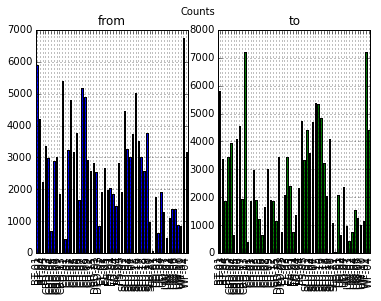

In [56]:
df_counts.plot(kind='bar', subplots=True, grid=True, title="Counts",
        layout=(1,2), sharex=True, sharey=False, legend=False)

**Question**: How do we make the plots bigger?

But this plot doesn't tell us about the *difference* between "from" and "to" counts. We want to subtract to_counts from from_counts. Will this difference be plottable?

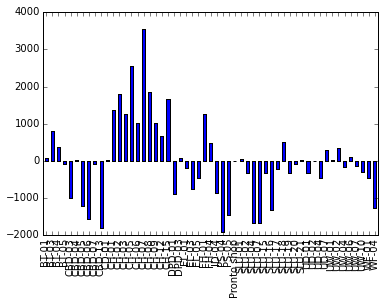

In [6]:
(from_counts-to_counts).plot.bar()

**Question**: How do we get rid of the garbage data for the station "Pronto"?

In [7]:
from_counts[from_counts.index=='Pronto shop']

Pronto shop    1
Name: from_station_id, dtype: int64

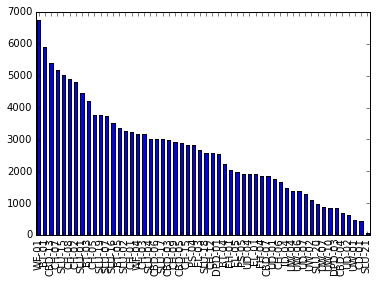

In [8]:
from_counts[from_counts.index!='Pronto shop'].plot.bar()

Some issues:
- Bogus value 'Pronto shop'
- Difficult to read the labels on the x-axis
- The x and y axis aren't labelled
- Lost information about "from" and "to"

## Writing a Data Cleansing Function

We want to get rid of the row 'Pronto shop' in both from_counts and to_counts.

In [9]:
# Selecting a row
from_counts[from_counts.index == 'Pronto shop']

Pronto shop    1
Name: from_station_id, dtype: int64

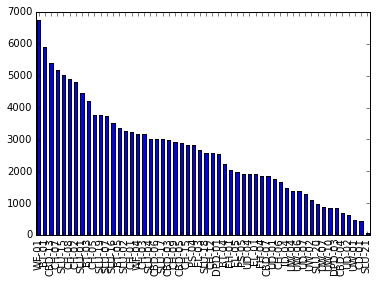

In [10]:
# Deleting a row
new_from_counts = from_counts[from_counts.index != 'Pronto shop']
new_from_counts.plot.bar()

In [11]:
def simple_clean_rows(df):
    """
    Removes from df all rows with the specified indexes
    :param pd.DataFrame or pd.Series df:
    :return pd.DataFrame or pd.Series:
    """
   
    df = df[df.index != 'Pronto Shop']
    return df

In [12]:
def clean_rows(df, indexes):
    """
    Removes from df all rows with the specified indexes
    :param pd.DataFrame or pd.Series df:
    :param list-of-str indexes
    :return pd.DataFrame or pd.Series:
    """
    for idx in indexes:
        df = df[df.index != idx]
    return df

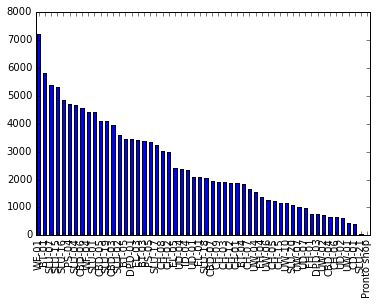

In [13]:
dff = clean_rows(to_counts, ['Pronto Shop', 'CBD-13'])
dff.plot.bar()

Does clean_rows need to return df to effect the change in df?

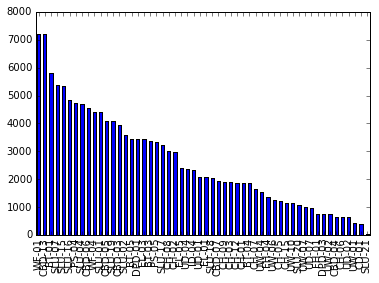

In [14]:
to_counts = clean_rows(to_counts, ['Pronto shop'])
to_counts.plot.bar()

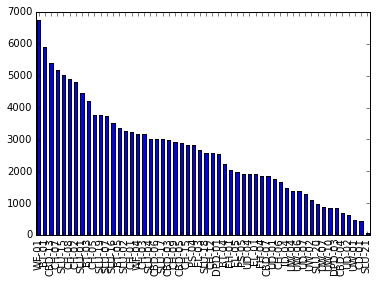

In [15]:
from_counts = clean_rows(from_counts, ['Pronto shop'])
from_counts.plot.bar()

In [16]:
to_counts.head()

WF-01     7212
CBD-13    7189
BT-01     5800
SLU-07    5390
SLU-15    5328
Name: to_station_id, dtype: int64

## Getting More Control Over Plots

*Let's take a more detailed approach to plotting so we can better control what gets rendered.*

In this section, we show how to control various elements of plots to produce a desired visualization. We'll use the package matplotlib, a python package that is modelled after MATLAB style plotting.

Make a dataframe out of the count data.

In [17]:
df_counts = pd.DataFrame({'From': from_counts.sort_index(), 'To': to_counts.sort_index()})

Need to align the counts by the station. Do we do this?

In [18]:
df_counts.head()

,From,To
BT-01,5885,5800
BT-03,4199,3386
BT-04,2221,1856
BT-05,3368,3459
CBD-03,2974,3959


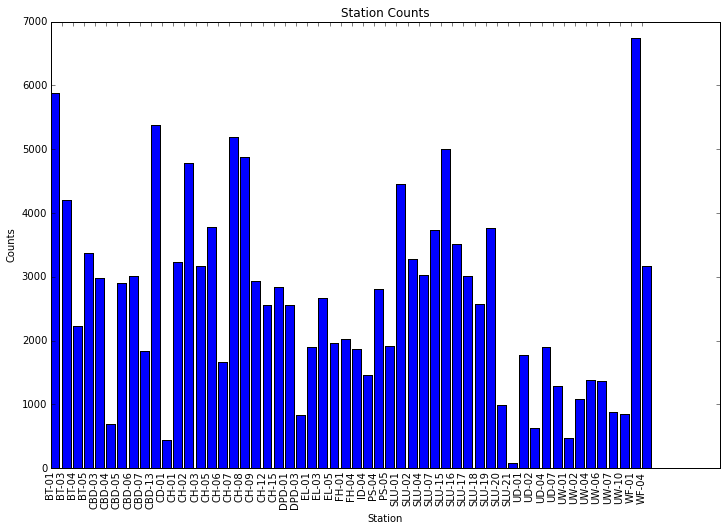

In [19]:
"""
Basic bar chart using matplotlib
"""
n_groups = len(df_counts.index)
index = np.arange(n_groups)  # The "raw" x-axis of the bar plot

fig = plt.figure(figsize=(12, 8))  # Controls global properties of the bar plot
rects1 = plt.bar(index, df_counts.From)
plt.xlabel('Station')
plt.ylabel('Counts')
plt.xticks(index, df_counts.index)  # Convert "raw" x-axis into labels
_, labels = plt.xticks()  # Get the new labels of the plot
plt.setp(labels, rotation=90)  # Rotate labels to make them readable
plt.title('Station Counts')
plt.show()

Issue - much more code, which will tend to be copied and pasted. 

Solution - **MAKE A FUNCTION NOW!!!**

In [20]:
def plot_bar1(df, column, opts):
    """
    Does a bar plot for a single column.
    :param pd.DataFrame df:
    :param str column: name of the column to plot
    :param dict opts: key is plot attribute
    """
    n_groups = len(df.index)
    index = np.arange(n_groups)  # The "raw" x-axis of the bar plot
    rects1 = plt.bar(index, df[column])
    if 'xlabel' in opts:
      plt.xlabel(opts['xlabel'])
    if 'ylabel' in opts:
      plt.ylabel(opts['ylabel'])
    if 'xticks' in opts and opts['xticks']:
      plt.xticks(index, df.index)  # Convert "raw" x-axis into labels
      _, labels = plt.xticks()  # Get the new labels of the plot
      plt.setp(labels, rotation=90)  # Rotate labels to make them readable
    else:
      labels = ['' for x in df.index]
      plt.xticks(index, labels)   
    if 'ylim' in opts:
      plt.ylim(opts['ylim'])
    if 'title' in opts:
      plt.title(opts['title'])

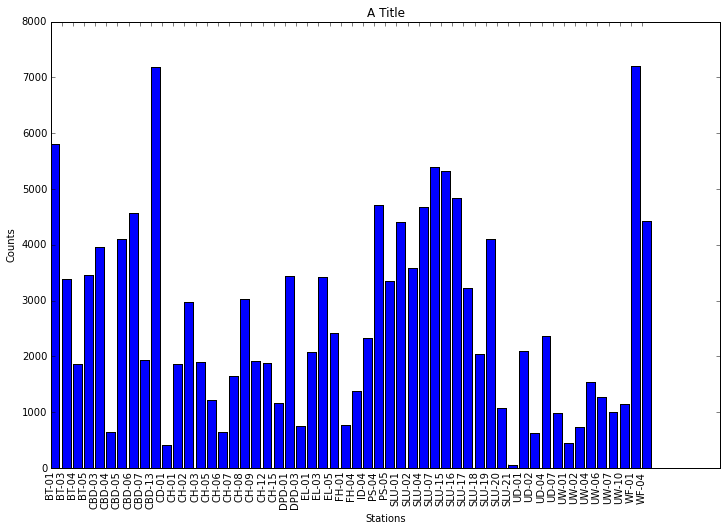

In [21]:
fig = plt.figure(figsize=(12, 8))  # Controls global properties of the bar plot
opts = {'xlabel': 'Stations', 'ylabel': 'Counts', 'xticks': True, 'title': 'A Title'}
plot_bar1(df_counts, 'To', opts)

<Container object of 10 artists>

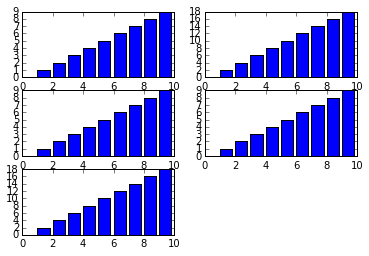

In [22]:
x = range(10)
y = [2*c for c in x]
plt.subplot(3, 2, 1)
plt.bar(x,x)
plt.subplot(3, 2, 2)
plt.bar(x,y)

plt.subplot(3, 2, 3)
plt.bar(x,x)
plt.subplot(3, 2, 4)
plt.bar(x,x)
plt.subplot(3, 2, 5)
plt.bar(x,y)

In [23]:
df_counts.head()

,From,To
BT-01,5885,5800
BT-03,4199,3386
BT-04,2221,1856
BT-05,3368,3459
CBD-03,2974,3959


**QUESTIONS** 
- Why is there no title for this plot? 
- How should we call plot_bar1 to get a title?

### Comparisons Using Subplots

We want to encapsulate the plotting of N variables into a function. We could re-write plot_bar1. But other plots use this. Besides plot_bar1 is pretty good at handling a single plot. So, instead we use plot_bar1 in a new function.

In [24]:
def plot_barN(df, columns, opts):
    """
    Does a bar plot for a single column.
    :param pd.DataFrame df:
    :param list-of-str columns: names of the column to plot
    :param dict opts: key is plot attribute
    """
    num_columns = len(columns)
    local_opts = dict(opts)  # Make a deep copy of the object
    idx = 0
    for column in columns:
        idx += 1
        local_opts['xticks'] = False
        local_opts['xlabel'] = ''
        if idx == num_columns:
          local_opts['xticks'] = True
          local_opts['xlabel'] = opts['xlabel']
        plt.subplot(num_columns, 1, idx)
        plot_bar1(df, column, local_opts)
    

**QUESTIONS**:
- Why is a new variable local_opts used in plot_barN instead of just changing opts?
- Why does the loop manipulate local_opts['xticks']? local_opts['xlabel']?

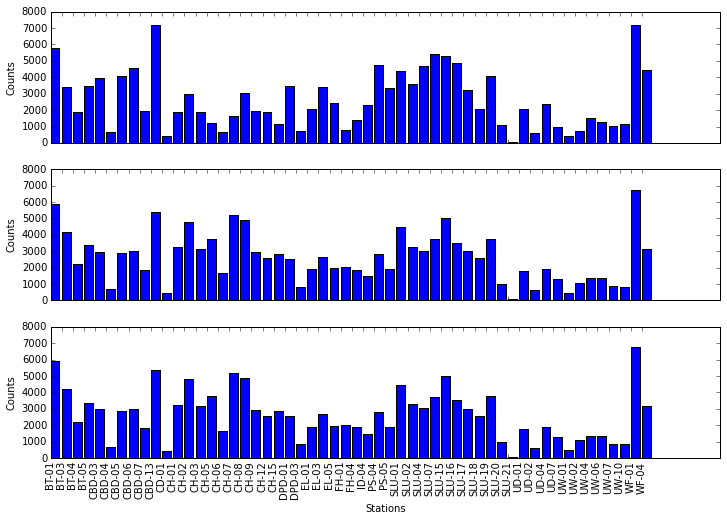

In [25]:
fig = plt.figure(figsize=(12, 8))  # Controls global properties of the bar plot
opts = {'xlabel': 'Stations', 'ylabel': 'Counts', 'ylim': [0, 8000]}
plot_barN(df_counts, ['To', 'From', 'From'], opts)

Issue - x-axis label overlaps second title.
Solution - eliminate the x-axis on the top plot

### Comparisons Using Multiple Bars In a Single Plot

To compare 'from' and 'to', we want:
- bars of different colors
- a legend

Unfortunately, we can't use plot_bar1 because it only accepts a single column as input.

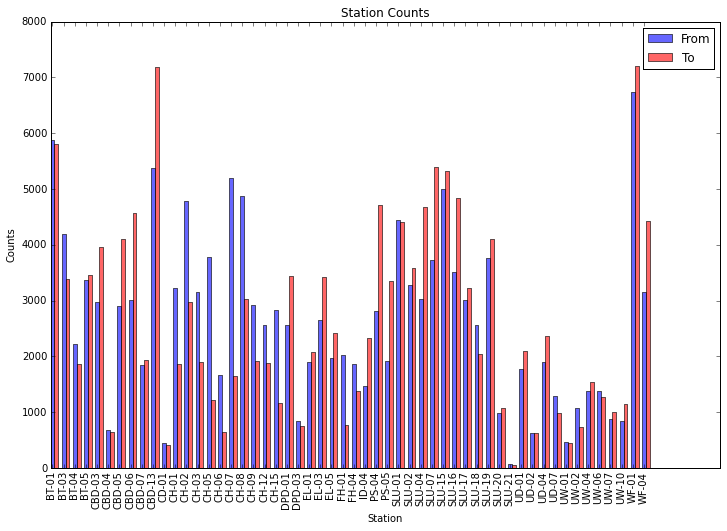

In [26]:
"""
Plotting two variables as a bar chart
"""
n_groups = len(df_counts.index)
index = np.arange(n_groups)  # The "raw" x-axis of the bar plot
fig = plt.figure(figsize=(12, 8))  # Controls global properties of the bar plot

#VVVV Changed to do two plots
bar_width = 0.35  # Width of the bars
opacity = 0.6  # How transparent the bars are
rects1 = plt.bar(index, df_counts.From, bar_width,
                 alpha=opacity,
                 color='b',
                 label='From')
rects2 = plt.bar(index + bar_width, df_counts.To, bar_width,
                 alpha=opacity,
                 color='r',
                 label='To')
plt.xticks(index + bar_width / 2, df_counts.index)
_, labels = plt.xticks()  # Get the new labels of the plot
plt.setp(labels, rotation=90)  # Rotate labels to make them readable
plt.legend()
#^^^^ Changed to do two plots

plt.xlabel('Station')
plt.ylabel('Counts')
plt.title('Station Counts')
plt.show()

## Including Error Bars in a Bar Chart

To make decisions about the truck trips required to adjust bikes at stations, we need to know the variations by day.

Want a bar plot with average daily "to" and "from" with their standard deviations.

### Data Preparation

Need to:
- Create day-of-year column for 'from' and 'to'
- Compute counts by date
- Compute the mean and standard deviation of the counts by date

(Assumes that a station has at least one rental every day.)

In [27]:
df.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1960
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1970
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1988
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1977
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1971


Let's start with the values for starttime. What type are these?

In [28]:
print (df.starttime[0])
print (type(df.starttime[0]))

10/13/2014 10:31
<type 'str'>


Question: How do we extract the day from a string?

YOU DON'T!!! You convert it to a datetime object.

In [29]:
this_datetime = pd.to_datetime(df.starttime[0])
print this_datetime

2014-10-13 10:31:00


In [30]:
this_datetime.dayofyear

286

In [31]:
start_day = []
for time in df.starttime:
    start_day.append(pd.to_datetime(time).dayofyear)

In [32]:
start_day[2]

286

In [33]:
start_day = [pd.to_datetime(time).dayofyear for time in df.starttime]
stop_day = [pd.to_datetime(x).dayofyear for x in df.stoptime]

In [34]:
df['startday'] = start_day  # Creates a new column named 'startday'
df['stopday'] = stop_day

In [35]:
df.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear,startday,stopday
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1960,286,286
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1970,286,286
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1988,286,286
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1977,286,286
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1971,286,286


In [36]:
groupby_day_from = df.groupby(['from_station_id', 'startday']).size()
groupby_day_from.head()

from_station_id  startday
BT-01            1           14
                 2            8
                 3            4
                 4            1
                 5            3
dtype: int64

In [37]:
groupby_day_to = df.groupby(['to_station_id', 'stopday']).size()
groupby_day_to.head()

to_station_id  stopday
BT-01          1          12
               2           2
               3           6
               4           1
               5           6
dtype: int64

Now we need to compute the average value and its standard deviation across the days for each station.
The groupby produced a MultiIndex. So, further operations on the result must take this into account.

In [38]:
h_index = groupby_day_from.index
h_index.levshape  # Size of the components of the MultiIndex

(55, 365)

In [39]:
from_means = groupby_day_from.groupby(level=[0]).mean()  # Computes the mean of counts by day
from_stds = groupby_day_from.groupby(level=[0]).std()   # Computes the standard deviation


In [40]:
groupby_day_to = df.groupby(['to_station_id', 'startday']).size()
to_means = groupby_day_to.groupby(level=[0]).mean()  # Computes the mean of counts by day
to_stds = groupby_day_to.groupby(level=[0]).std()   # Computes the standard deviation

In [41]:
df_day_counts = pd.DataFrame({'from_mean': from_means, 'from_std': from_stds, 'to_mean': to_means, 'to_std': to_stds})
df_day_counts.head()

,from_mean,from_std,to_mean,to_std
from_station_id,,,,
BT-01,16.167582,11.459929,16.022099,11.649049
BT-03,11.599448,5.791607,9.276712,4.882986
BT-04,6.256338,3.510949,5.411079,2.896377
BT-05,9.329640,5.128833,9.635097,5.111931
CBD-03,8.238227,5.803139,10.876374,6.287737


### Plotting with Error Bars

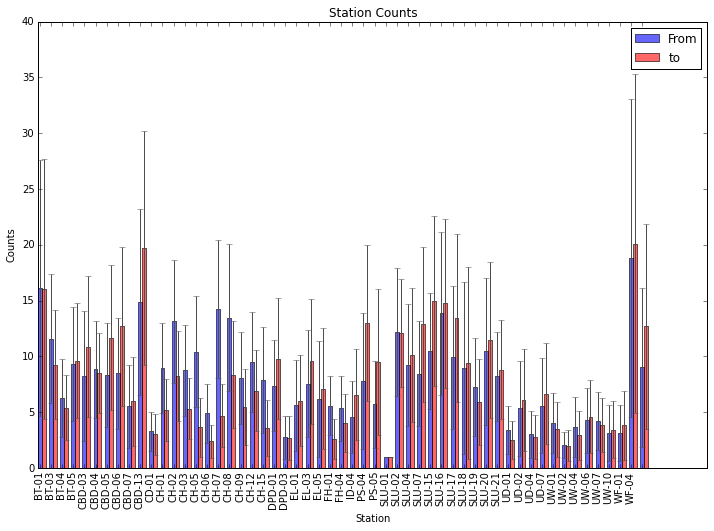

In [42]:
"""
Plotting two variables as a bar chart with error bars
"""
n_groups = len(df_day_counts.index)
index = np.arange(n_groups)  # The "raw" x-axis of the bar plot
fig = plt.figure(figsize=(12, 8))  # Controls global properties of the bar plot
bar_width = 0.35  # Width of the bars
opacity = 0.6  # How transparent the bars are

#VVVV Changed to do two plots with error bars
error_config = {'ecolor': '0.3'}
rects1 = plt.bar(index, df_day_counts.from_mean, bar_width,
                 alpha=opacity,
                 color='b',
                 yerr=df_day_counts.from_std,
                 error_kw=error_config,
                 label='From')
rects2 = plt.bar(index + bar_width, df_day_counts.to_mean, bar_width,
                 alpha=opacity,
                 color='r',
                 yerr=df_day_counts.to_std,
                 error_kw=error_config,
                 label='to')
#^^^^ Changed to do two plots with error bars

plt.xticks(index + bar_width / 2, df_counts.index)
_, labels = plt.xticks()  # Get the new labels of the plot
plt.setp(labels, rotation=90)  # Rotate labels to make them readable
plt.legend()

plt.xlabel('Station')
plt.ylabel('Counts')
plt.title('Station Counts')
plt.show()

## In-class exercise
Change the above script for plotting with error bars into a function and verify that you can call this function and get the same plot as the one above.
* What are the inputs to your function and why?
* How would you change plot_barN to use this function?